In [5]:
import pandas, numpy, os, seaborn, matplotlib

%matplotlib inline
pandas.options.display.max_rows=100
pandas.options.display.max_columns=1000
seaborn.set_style("white")
seaborn.set_style("ticks")
font_size = 7
matplotlib.rcParams['svg.fonttype'] = 'none' # none, path, or svgfont
matplotlib.rcParams['axes.titlepad'] = 3
matplotlib.rcParams['axes.labelpad'] = 3
matplotlib.rcParams['font.size'] = font_size
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['svg.fonttype'] = 'none' # none, path, or svgfont

In [6]:
sra_date='2018_5_1'

os.chdir('/Users/kf/Dropbox/kfdata/02_Data/my_db/Ensembl/release-91/sra/'+sra_date)

file_sra="/Users/kf/Dropbox/kfdata/02_Data/my_db/Ensembl/release-91/sra/"+sra_date+"/sra_table_curated_"+sra_date+".tsv"
file_sra_amalgamated="/Users/kf/Dropbox/kfdata/02_Data/my_db/Ensembl/release-91/sra/"+sra_date+"/sra_table_amalgamated_"+sra_date+".tsv"

dir_kallisto='/Users/kf/Dropbox/kfdata/02_Data/my_db/Ensembl/release-91/kallisto_summary/'+sra_date+'/'

dir_tpm_unfiltered=dir_kallisto+'tpm.unfiltered.kallisto.tsv/'
dir_tpm_fastp=dir_kallisto+'tpm.fastp.kallisto.tsv/'
dir_tpm_masked=dir_kallisto+'tpm.masked.kallisto.tsv/'

dir_ec_unfiltered=dir_kallisto+'est_counts.unfiltered.kallisto.tsv/'
dir_ec_fastp=dir_kallisto+'est_counts.fastp.kallisto.tsv/'
dir_ec_masked=dir_kallisto+'est_counts.masked.kallisto.tsv/'

dir_fatt=dir_kallisto+'fatt.tsv/'

In [3]:
sra = pandas.read_csv(file_sra, sep='\t')

steps = ['unfiltered','fastp','masked']
col1 = ['run', 'layout']
col2 = [ c1+c2 for c1 in ['num_read_','total_nucl_','avg_read_len_','min_read_len_','max_read_len_'] for c2 in steps ]
cols = col1 + col2

# Annotate fatt statistics
exts = {'unfiltered':'.*(_1|_2|[0-9]{2,})\.fastq$', 
        'fastp':'.*[0-9]\.fastp\.fastq$', 
        'masked':'.*[0-9]*\.masked\..*fastq$',
       }
df_fatt1 = pandas.DataFrame()
df_in = pandas.DataFrame()
files = os.listdir(dir_fatt)
for file in files:
    if (os.path.getsize(dir_fatt+file)>10)&(file!='.DS_Store'):
        df_in = df_in.append(pandas.read_csv(dir_fatt+file, sep='\t'))
print('Number of fatt record before dropping duplicates:', df_in.shape[0])
df_in = df_in.drop_duplicates()
print('Number of fatt record after dropping duplicates:', df_in.shape[0])
for item in exts.items():
    a = item[0]
    ext = item[1]
    df1 = df_in.loc[df_in['FILE'].str.match(ext),:]
    df1.loc[:,'FILE'] = df1.loc[:,'FILE'].replace('_.*', '', regex=True).replace('\..*', '', regex=True)
    if a=='unfiltered':
        tmp = pandas.DataFrame(df1.groupby('FILE')['NUM_READS'].count()); tmp.columns = ['layout']
        df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
    tmp = pandas.DataFrame(df1.groupby('FILE')['NUM_READS'].mean()); tmp.columns = ['num_read_'+a]
    df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
    tmp = pandas.DataFrame(df1.groupby('FILE')['NUM_NUCLS'].sum()); tmp.columns = ['total_nucl_'+a]
    df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
    tmp = pandas.DataFrame(df1.groupby('FILE')['AVG_READ_LEN'].mean()); tmp.columns = ['avg_read_len_'+a]
    df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
    tmp = pandas.DataFrame(df1.groupby('FILE')['MIN_READ_LEN'].min()); tmp.columns = ['min_read_len_'+a]
    df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
    tmp = pandas.DataFrame(df1.groupby('FILE')['MAX_READ_LEN'].max()); tmp.columns = ['max_read_len_'+a]
    df_fatt1 = pandas.merge(df_fatt1, tmp, left_index=True, right_index=True, how='outer')
df_fatt1['run'] = df_fatt1.index
df_fatt1 = df_fatt1.loc[~df_fatt1['run'].duplicated(),cols]
sra = pandas.merge(sra, df_fatt1, on='run', how='left')

# Annotate kallisto statistics
indirs = [dir_ec_unfiltered,dir_ec_fastp,dir_ec_masked]
for indir,ext in zip(indirs,steps):
    files = os.listdir(indir)
    mapped_reads = pandas.Series()
    for file in files:
        if os.path.getsize(indir+file)>10:
            df = pandas.read_csv(indir+file, sep='\t')
            sra_cols = df.columns[~df.columns.isin(['target_id','length'])]
            tmp_mapped_reads = df.loc[:,sra_cols].sum(axis=0)
            mapped_reads = mapped_reads.append(tmp_mapped_reads)
    mapped_reads = pandas.DataFrame(mapped_reads)
    mapped_reads.columns = ['mapped_read_'+ext,]
    mapped_reads['run'] = mapped_reads.index
    sra = pandas.merge(sra, mapped_reads, on='run', how='left')
    
for ext in steps:
    sra.loc[(sra['num_read_'+ext]==0),'num_read_'+ext] = numpy.nan
    sra['mapping_rate_'+ext] = sra['mapped_read_'+ext] / sra['num_read_'+ext]


/Users/kf/anaconda/envs/ete3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of fatt record before dropping duplicates: 16357
Number of fatt record after dropping duplicates: 16357


/Users/kf/anaconda/envs/ete3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


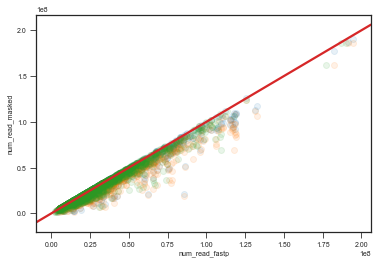

In [4]:
seaborn.regplot(x='num_read_unfiltered', y='num_read_fastp', data=sra, fit_reg=False, scatter_kws={'alpha':0.1}) # blue
seaborn.regplot(x='num_read_unfiltered', y='num_read_masked', data=sra, fit_reg=False, scatter_kws={'alpha':0.1}) # orange
seaborn.regplot(x='num_read_fastp', y='num_read_masked', data=sra, fit_reg=False, scatter_kws={'alpha':0.1}) # green
seaborn.regplot(x=numpy.arange(0,0.2,0.01), y=numpy.arange(0,0.2,0.01), scatter=False)

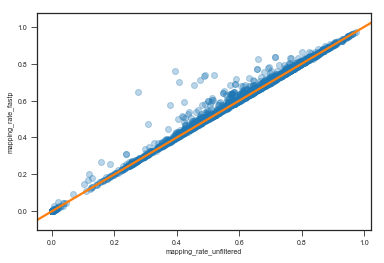

In [5]:
seaborn.regplot(x='mapping_rate_unfiltered', y='mapping_rate_fastp', data=sra, fit_reg=False, scatter_kws={'alpha':0.3}) # blue
#seaborn.regplot(x='mapping_rate_unfiltered', y='mapping_rate_masked', data=sra, fit_reg=False, scatter_kws={'alpha':0.1}) # orange
#seaborn.regplot(x='mapping_rate_fastp', y='mapping_rate_masked', data=sra, fit_reg=False, scatter_kws={'alpha':0.1}) # green
seaborn.regplot(x=numpy.arange(0,0.2,0.01), y=numpy.arange(0,0.2,0.01), scatter=False)

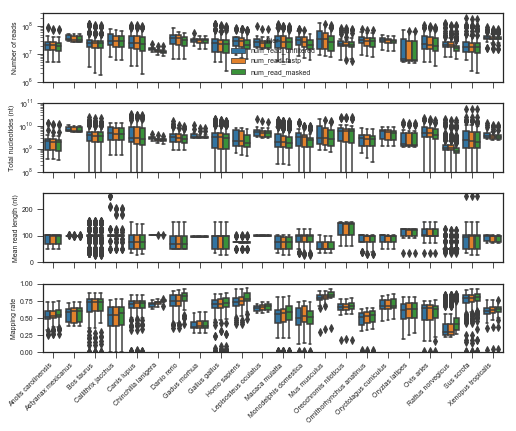

In [6]:
def plot_transcriptome_curation(sra, spp=[]):
    cols = ['num_read', 'total_nucl', 'avg_read_len', 'mapping_rate']
    ylabs = ['Number of reads', 'Total nucleotides (nt)', 'Mean read length (nt)', 'Mapping rate']
    ylims = [[10**6, (10**9)*0.3],[10**8, 10**11],[0, 260],[0,1]]
    num_row = len(cols)
    num_col = 1
    # full figure size = 9.7 length x 7.2 width in inches
    fig,axes = matplotlib.pyplot.subplots(nrows=num_row, ncols=num_col, figsize=(7.2,1.5*num_row), sharex=True, sharey=False)
    axes = axes.flat
    ind = 0
    for col in cols:
        if len(spp):
            df_plot = sra.loc[sra.scientific_name.isin(spp),:]
        else:
            df_plot = sra
        df_plot.index = df_plot['scientific_name']
        df_plot = df_plot.loc[:,[col+'_unfiltered', col+'_fastp', col+'_masked']]
        df_plot = df_plot.stack().reset_index()
        df_plot.columns = ['scientific_name', 'filter', 'value']        
        #ax = seaborn.stripplot(x='scientific_name', y='value', hue='filter', data=df_plot, ax=axes[ind], jitter=True, dodge=True, alpha=0.2, edgecolor='gray')
        #ax = seaborn.violinplot(x='scientific_name', y='value', hue='filter', data=df_plot, ax=axes[ind])
        ax = seaborn.boxplot(x='scientific_name', y='value', hue='filter', data=df_plot, ax=axes[ind])
        xlabels = ax.get_xmajorticklabels()
        for xlabel in xlabels:
            xlabel.set_rotation(45)
            xlabel.set_horizontalalignment("right")
        if col in ['num_read', 'total_nucl']:
            ax.set(yscale="log")
        ax.set_xlabel('')
        ax.set_ylabel(ylabs[ind])
        ax.set_ylim(ylims[ind])
        if ind==0:
            ax.legend_.loc = 3
        else:
            ax.legend_ = None
        ind += 1
    return fig,axes

spp = ['Bos taurus','Homo sapiens','Gallus gallus','Macaca mulatta','Canis lupus','Sus scrofa','Ovis aries','Mus musculus','Callithrix jacchus',
'Rattus norvegicus','Monodelphis domestica','Oreochromis niloticus','Oryctolagus cuniculus','Danio rerio','Anolis carolinensis','Chinchilla lanigera',
'Astyanax mexicanus','Lepisosteus oculatus','Xenopus tropicalis','Oryzias latipes','Gadus morhua','Ornithorhynchus anatinus']

fig,axes = plot_transcriptome_curation(sra, spp)

fig.tight_layout()
outbase = 'mapping_rate_curated'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

In [7]:
sra.to_csv(file_sra.replace('curated', 'mapped'), sep='\t', index=False)

Running: make_cross_tables


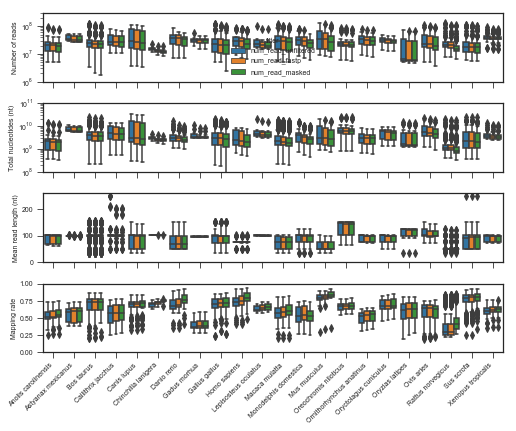

In [8]:
# Run after an amalgamated table is created.

sra_amalgamated = pandas.read_csv(file_sra_amalgamated, sep='\t')
sra_amalgamated = sra_amalgamated.loc[(sra_amalgamated['exclusion']=='no'),:]

fig,axes = plot_transcriptome_curation(sra_amalgamated, spp)

fig.tight_layout()
outbase = 'mapping_rate_amalgamated'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

def make_cross_tables(sra_table, n_sp_cutoff=5, suppress_tissue=True, sample_upper=True):
    print('Running: make_cross_tables')
    if suppress_tissue:
        sra_table = sra_table.loc[sra_table['is_selected_tissue']=='Yes',:]
    if sample_upper:
        sra_table = sra_table.loc[sra_table['is_sampled']=='Yes',:]    
    sra_reduced = sra_table[['scientific_name', 'biosample', 'tissue']]
    sra_pivot = sra_reduced.pivot_table(columns='tissue',index='scientific_name', aggfunc='count')
    sra_pivot.columns = sra_pivot.columns.get_level_values(1)
    column_sort = sra_pivot.count(axis='index').sort_values(ascending=False).index
    index_sort = sra_pivot.count(axis='columns').sort_values(ascending=False).index
    sra_pivot = sra_pivot.loc[index_sort,column_sort]
    sra_pivot_reduced = sra_pivot.loc[:,sra_pivot.count(axis='index') >= n_sp_cutoff]
    column_sort = sra_pivot_reduced.count(axis='index').sort_values(ascending=False).index
    index_sort = sra_pivot_reduced.count(axis='columns').sort_values(ascending=False).index
    sra_pivot_reduced = sra_pivot_reduced.loc[index_sort,column_sort]
    return sra_pivot_reduced

d = '2018_5_1'
sra_amalgamated_pivot = make_cross_tables(sra_amalgamated, n_sp_cutoff=5, suppress_tissue=False, sample_upper=False)
sra_amalgamated_pivot.to_csv('sra_table_pivot_amalgamated_'+d+'.tsv', sep='\t')

In [18]:
# Run after an amalgamated table is created.

spp = ['Bos taurus','Homo sapiens','Gallus gallus','Macaca mulatta','Canis lupus','Sus scrofa','Ovis aries','Mus musculus','Callithrix jacchus',
'Rattus norvegicus','Monodelphis domestica','Oreochromis niloticus','Oryctolagus cuniculus','Danio rerio','Anolis carolinensis','Chinchilla lanigera',
'Astyanax mexicanus','Lepisosteus oculatus','Xenopus tropicalis','Oryzias latipes','Gadus morhua','Ornithorhynchus anatinus']

sra_amalgamated = pandas.read_csv(file_sra_amalgamated, sep='\t')
piv = sra_amalgamated.loc[:,['scientific_name','exclusion','run']].groupby(['scientific_name','exclusion']).count().unstack().fillna(0).T.astype(int)
piv = piv.loc[:,sorted(spp)]
piv.to_csv('sample_exclusion.tsv', sep='\t', index=True)

#seaborn.barplot(x='exclusion',)